<div style="background-color:#8B0000; border-radius:5px; border:#ffffff solid; padding: 20px; font-size:120%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>Potato Disease Classification</b></h1>
</div>

Import Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# Set All The Constant

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE  = 255
CHNNELS = 3
EPOCHS = 5

<div style="background-color:#8B0000; border-radius:5px; border:#ffffff solid; padding: 20px; font-size:120%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>Import data into tensorflow dataset object</b></h1>
</div>

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/potato-disease',
    seed = 123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 255, 255, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

# Visualize some of the images from our dataset

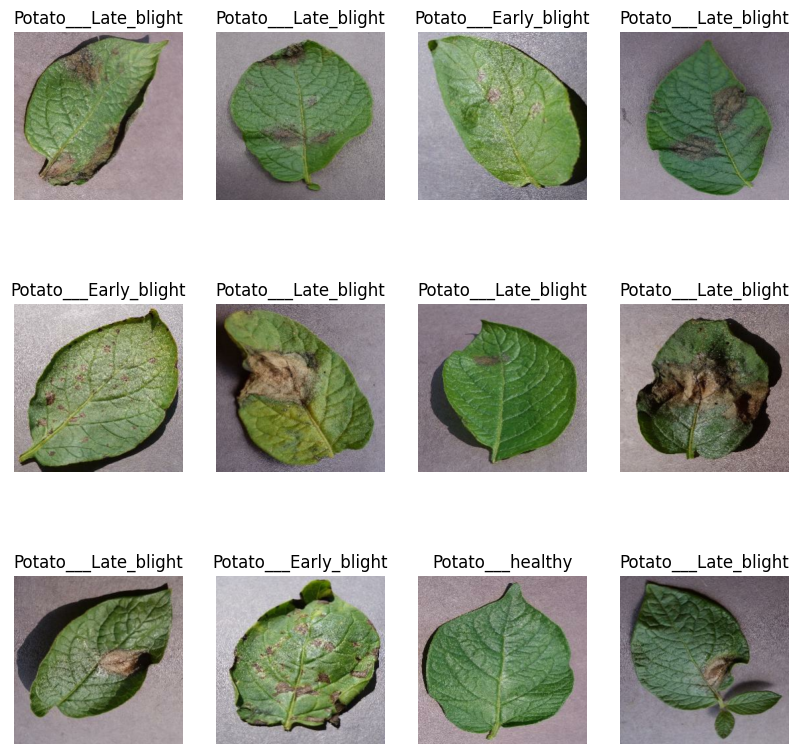

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off') 

plt.show()


# Funtion to split dataset

Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(test_ds)

8

In [21]:
len(val_ds)

6

# Cache, Shuffle, and Prefetch the Dataset

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)




# Building the Model

<div style="background-color:#8B0000; border-radius:5px; border:#ffffff solid; padding: 20px; font-size:120%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>Creating a Layer for Resizing and Normalization</b></h1>
</div>

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

# Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Applying Data Augmentation to Train Dataset

In [28]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size= tf.data.AUTOTUNE)

<div style="background-color:#8B0000; border-radius:5px; border:#ffffff solid; padding: 20px; font-size:120%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>Model Architecture</b></h1>
</div>

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN****

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHNNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size= (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])
model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [38]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy']
             )

In [39]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)

Epoch 1/50
54/54 [==============================] - 121s 2s/step - loss: 0.9016 - accuracy: 0.5069 - val_loss: 0.8421 - val_accuracy: 0.5625
Epoch 2/50
54/54 [==============================] - 112s 2s/step - loss: 0.6671 - accuracy: 0.6997 - val_loss: 0.5716 - val_accuracy: 0.7500
Epoch 3/50
54/54 [==============================] - 111s 2s/step - loss: 0.4734 - accuracy: 0.8021 - val_loss: 0.5326 - val_accuracy: 0.7760
Epoch 4/50
54/54 [==============================] - 111s 2s/step - loss: 0.3910 - accuracy: 0.8409 - val_loss: 0.2373 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 110s 2s/step - loss: 0.2810 - accuracy: 0.8924 - val_loss: 0.1976 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 110s 2s/step - loss: 0.2585 - accuracy: 0.8964 - val_loss: 0.4080 - val_accuracy: 0.8021
Epoch 7/50
54/54 [==============================] - 110s 2s/step - loss: 0.2617 - accuracy: 0.8964 - val_loss: 0.1319 - val_accuracy: 0.9427
Epoch 8/50
54

In [40]:
model.evaluate(test_ds)

8/8 [==============================] - 7s 568ms/step - loss: 0.1266 - accuracy: 0.9648


[0.12656523287296295, 0.96484375]

# Plotting the Accuracy and Loss Curves

In [41]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [42]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [44]:
len(history.history['loss'])

50

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']

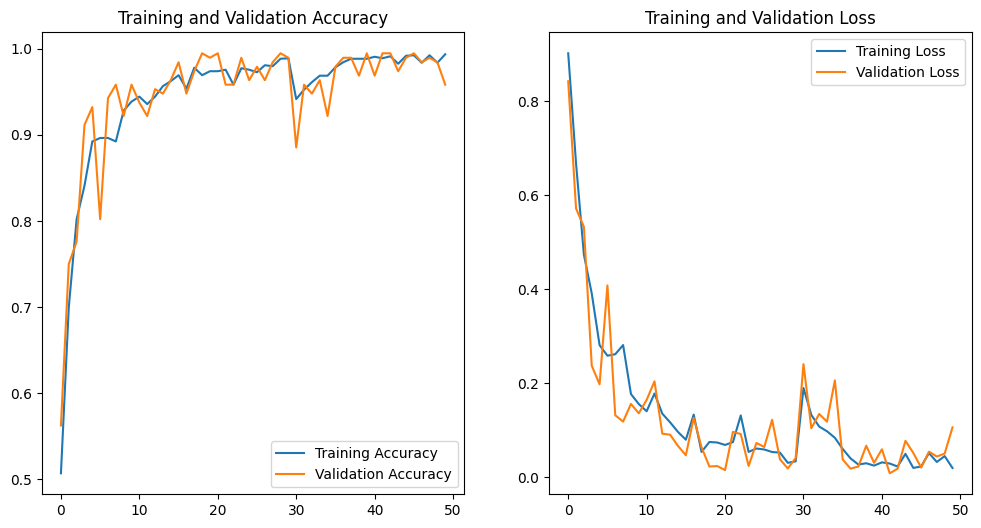

In [48]:
import matplotlib.pyplot as plt

# Assuming EPOCHS is the length of your data
EPOCHS = len(acc)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


# Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 759ms/step
predicted label: Potato___Early_blight


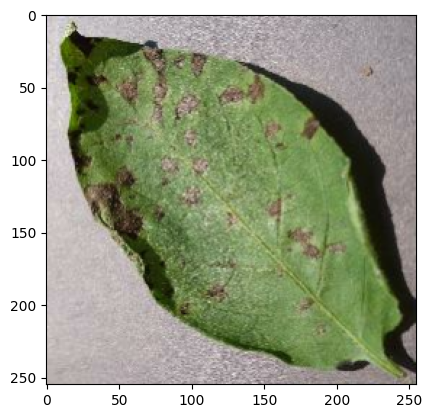

In [50]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Now run inference on few sample images

1/1 [==============================] - 0s 40ms/step


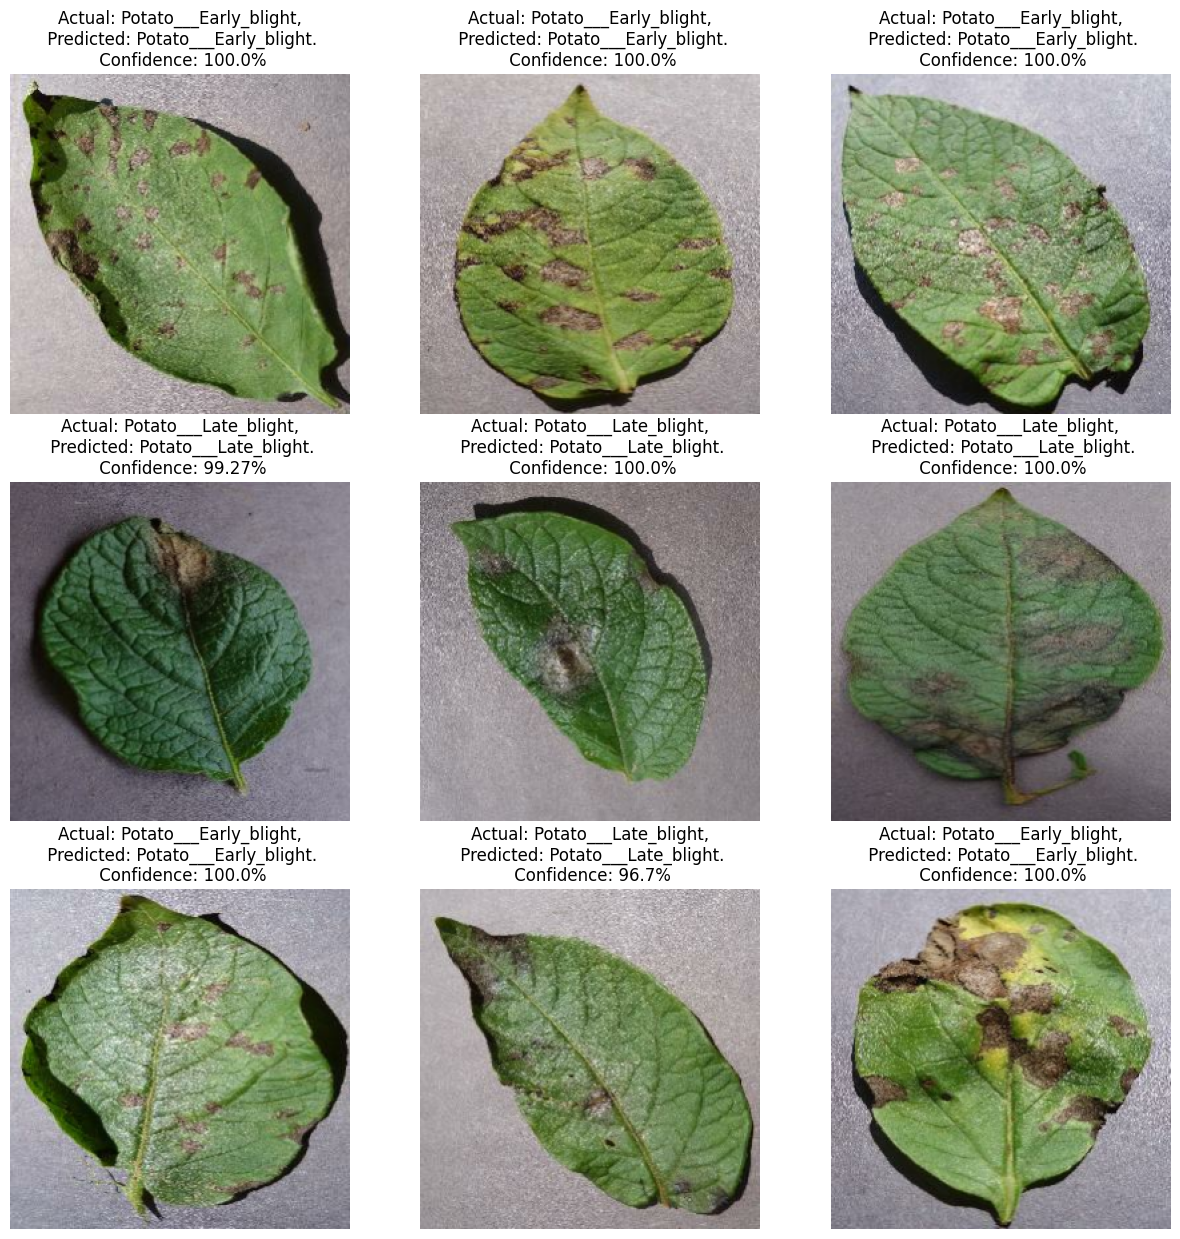

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

We append the model to the list of models as a new version

In [59]:
import os

# List comprehension to filter out non-integer entries
model_versions = [int(i) for i in os.listdir("/kaggle/working/") if i.isdigit()]

# Get the maximum version or default to 0 if the list is empty
model_version = max(model_versions, default=0) + 1

model.save(f"/kaggle/working/{model_version}")


In [60]:
model.save("../potatoes.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Dowload model folders from kaggle

In [66]:

import shutil
# from google.colab import files

# Specify the folder path on Kaggle
folder_path_on_kaggle = "/kaggle/working/1"

# Specify the local destination path for the zip file
local_zip_destination = "downloaded_folder.zip"

# Create a zip file of the folder
shutil.make_archive(local_zip_destination[:-4], 'zip', folder_path_on_kaggle)

# Download the zip file
# files.download(local_zip_destination)


'/kaggle/working/downloaded_folder.zip'